In [ ]:
# pip install torchmetrics
# pip install stepmix
# pip install kneed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
from joblib import Parallel, delayed # for parallelization
from itertools import product

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, HDBSCAN
from stepmix.stepmix import StepMix

# Evaluation
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import torch
from torchmetrics.clustering import DunnIndex
from collections import Counter
from kneed import KneeLocator

# Visualization
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull

# Preparation
## Data

In [2]:
data2004_i = pd.read_parquet("data/data2004_i.parquet") # load imputed data

# Dataset with numeric outcomes
data_n = data2004_i[[
    'clseusa_n', 'ambornin_n', 'amcit_n', 'amlived_n', 'amenglsh_n', 
     'amchrstn_n', 'amgovt_n', 'amfeel_n', 'amcitizn_n', 'amshamed_n', 
     'belikeus_n', 'ambetter_n', 'ifwrong_n', 'proudsss_n', 'proudgrp_n', 
     'proudpol_n', 'prouddem_n', 'proudeco_n', 'proudspt_n', 'proudart_n', 
     'proudhis_n', 'proudmil_n', 'proudsci_n']]

# Dataset with categorical outcomes
data_f = data2004_i[[
     'clseusa_f', 'ambornin_f', 'amcit_f', 'amlived_f', 'amenglsh_f', 
     'amchrstn_f', 'amgovt_f', 'amfeel_f', 'amcitizn_f', 'amshamed_f', 
     'belikeus_f', 'ambetter_f', 'ifwrong_f', 'proudsss_f', 'proudgrp_f', 
     'proudpol_f', 'prouddem_f', 'proudeco_f', 'proudspt_f', 'proudart_f', 
     'proudhis_f', 'proudmil_f', 'proudsci_f']]

# Dataset with controls
controls = data2004_i[[
    'sex', 'race_f', 'born_usa', 'party_fs', 'religstr_f', 
    'reltrad_f', 'region_f']]

## Validity indexes

In [3]:
# Custom score functions to avoid throwing errors when undefined
def sil_score(data, pred_clust):
    try:
        sil_score = silhouette_score(data, pred_clust)
    except ValueError:
        sil_score = np.nan
    return sil_score

def ch_score(data, pred_clust):
    try:
        ch_score = calinski_harabasz_score(data, pred_clust)
    except ValueError:
        ch_score = np.nan
    return ch_score

def db_score(data, pred_clust):
    try:
        db_score = davies_bouldin_score(data, pred_clust)
    except ValueError:
        db_score = np.nan
    return db_score

def dunn_score(data, pred_clust):
    torch_data = np.array(data)
    torch_data = torch.tensor(torch_data, dtype=torch.float32)
    torch_pred_clust = torch.tensor(pred_clust, dtype=torch.int64)

    dunn_metric = DunnIndex()
    
    try:
        dunn_score = float(dunn_metric(torch_data, torch_pred_clust))
    except Exception:
        dunn_score = np.nan
 
    return dunn_score

def inertia(data, labels):
    data = np.asarray(data)
    
    inertia = 0
    for cluster in np.unique(labels):
        cluster_points = data[labels == cluster]
        cluster_centroid = np.mean(cluster_points, axis=0)
        inertia += np.sum((cluster_points - cluster_centroid) ** 2)
        
    return inertia

def clust_size(labels):
    cluster_sizes = Counter(labels)
    min_size = min(cluster_sizes.values())
    max_size = max(cluster_sizes.values())
    
    return min_size, max_size

In [4]:
# Function to return all validity indexes at once
def get_metrics(model, params, n, data, pred_clust, **additional_metrics):
    base_metrics = {
        'model': model,
        'params': params,
        'n_clust': n,
        'min_clust_size': clust_size(pred_clust)[0],
        'max_clust_size': clust_size(pred_clust)[1],
        'silhouette': sil_score(data, pred_clust),
        'calinski_harabasz': ch_score(data, pred_clust),
        'davies_bouldin': db_score(data, pred_clust),
        'dunn': dunn_score(data, pred_clust),
        'inertia': inertia(data, pred_clust)
    }

    base_metrics.update(additional_metrics)
    return base_metrics

In [5]:
# Function to display the optimal numbers of clutsters according to each validity index
def elbow_plot(df, val_index):
    res = df.dropna(subset=[val_index])

    x = res["n_clust"]
    y = res[val_index]

    if val_index in ['davies_bouldin', 'entropy']:
        knee_locator = KneeLocator(x, y, curve='concave', direction='increasing')
    else:
        knee_locator = KneeLocator(x, y, curve='convex', direction='decreasing')

    plt.figure(figsize=(8, 4))
    plt.plot(x, y, marker="o", linestyle="-", label=val_index)
    plt.axvline(x=knee_locator.knee, color="r", linestyle="--", label=f"Optimal k={knee_locator.knee}")
    plt.xlabel("Number of Clusters")
    plt.ylabel(f"{val_index} index")
    plt.title(f"Elbow Method for {val_index} index")
    plt.legend()
    plt.show()

## Parameters

In [6]:
max_clust = 12
max_threads = 8

val_indexes = ['silhouette', 'calinski_harabasz', 'davies_bouldin', 'dunn', 'inertia']

# Latent models
With the StepMix package, see: https://github.com/Labo-Lacourse/stepmix

In [7]:
# Parameters
clust_range = range(1, max_clust+1)

opt_params = {
    'method': 'gradient',
    'intercept': True,
    'max_iter': 2500,
}

In [8]:
# Without covariates
def do_StepMix(n, type, data):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)

        latent_mod = StepMix(
            n_components = n, 
            measurement = type, 
            n_init = 3,
            init_params = 'kmeans',
            structural_params = opt_params,
            random_state = 123)
        
        latent_mod.fit(data)
        pred_clust = latent_mod.predict(data)

        model = 'LCA' if type == 'categorical' else 'LPA'
        params = 'without covariates'
        loglik = latent_mod.score(data)
        aic = latent_mod.aic(data)
        bic = latent_mod.aic(data)
        entropy = latent_mod.entropy(data)

    return get_metrics(model, params, n, data, pred_clust, LL = loglik, aic = aic, bic = bic, entropy = entropy)

data = data_f.apply(lambda col: LabelEncoder().fit_transform(col))
cat_results = Parallel(n_jobs=8)(delayed(do_StepMix)(n, 'categorical', data) for n in clust_range)
LCA_all = pd.DataFrame(cat_results)

# Data preprocessing?
num_results = Parallel(n_jobs=8)(delayed(do_StepMix)(n, 'continuous', data_n) for n in clust_range)
LPA_all = pd.DataFrame(num_results)

Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...


Initializations (n_init) : 100%|██████████| 3/3 [00:00<00:00,  9.97it/s, max_LL=-2.82e+4, max_avg_LL=-23.2]


Fitting StepMix...
Fitting StepMix...


Initializations (n_init) :  33%|███▎      | 1/3 [00:00<00:01,  1.27it/s, max_LL=-2.69e+4, max_avg_LL=-22.1]

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 3/3 [00:00<00:00, 25.91it/s, max_LL=-1.1e+4, max_avg_LL=-9.04]


Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...


Initializations (n_init) : 100%|██████████| 3/3 [00:00<00:00, 20.09it/s, max_LL=-7.37e+3, max_avg_LL=-6.07]


In [ ]:
for val_index in val_indexes + ['aic', 'bic', 'entropy']:
    elbow_plot(LCA_all, val_index)

In [9]:
# With covariates
def do_StepMix_covar(n, type, data):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        
        latent_mod = StepMix(
            n_components = n,
            measurement = type,
            n_init = 3,
            init_params = 'kmeans',
            structural = 'covariate', 
            n_steps = 1,
            structural_params = opt_params,
            random_state = 123)
        
        latent_mod.fit(data, controls_dum)
        pred_clust = latent_mod.predict(data)
        
        model = 'LCA' if type == 'categorical' else 'LPA'
        params = 'with covariates'
        loglik = latent_mod.score(data)
        aic = latent_mod.aic(data)
        bic = latent_mod.aic(data)
        entropy = latent_mod.entropy(data)

    return get_metrics(model, params, n, data, pred_clust, LL = loglik, aic = aic, bic = bic, entropy = entropy)

controls_dum = pd.get_dummies(controls)

data = data_f.apply(lambda col: LabelEncoder().fit_transform(col))
cat_results = Parallel(n_jobs=max_threads)(delayed(do_StepMix_covar)(n, 'categorical', data) for n in clust_range)
LCA_covar_all = pd.DataFrame(cat_results)

# Data preprocessing?
num_results = Parallel(n_jobs=max_threads)(delayed(do_StepMix_covar)(n, 'continuous', data_n) for n in clust_range)
LPA_covar_all = pd.DataFrame(num_results)

Initializations (n_init) :   0%|          | 0/3 [00:00<?, ?it/s]

Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...


Initializations (n_init) :   0%|          | 0/3 [00:00<?, ?it/s]

Fitting StepMix...


Initializations (n_init) :   0%|          | 0/3 [00:00<?, ?it/s]

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 3/3 [13:53<00:00, 277.86s/it, max_LL=-2.75e+4, max_avg_LL=-22.7]
/Users/mael/.pyenv/versions/3.10.16/envs/tensor/lib/python3.10/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Initializations (n_init) :   0%|          | 0/3 [00:00<?, ?it/s]

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 3/3 [15:11<00:00, 303.91s/it, max_LL=-2.73e+4, max_avg_LL=-22.5]
/Users/mael/.pyenv/versions/3.10.16/envs/tensor/lib/python3.10/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Initializations (n_init) : 100%|██████████| 3/3 [15:21<00:00, 307.10s/it, max_LL=-2.69e+4, max_avg_LL=-22.2]
/Users/mael/.pyenv/versions/3.10.16/envs/tensor/lib/python3.10/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Initializations (n_init) : 100%|██████████| 3/3 [16:18<00:00, 326.13s/it, max_LL=-2.66e+4, max_avg_LL=-21.9]
/Users/mael/.pyenv/versions/3.10.16/envs/tensor/lib/python3.10/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initiali

Fitting StepMix...


Initializations (n_init) :   0%|          | 0/3 [00:00<?, ?it/s]

Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...
Fitting StepMix...


Initializations (n_init) :   0%|          | 0/3 [00:00<?, ?it/s]

Fitting StepMix...


Initializations (n_init) :   0%|          | 0/3 [00:00<?, ?it/s]

Fitting StepMix...


Initializations (n_init) :   0%|          | 0/3 [00:00<?, ?it/s]

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 3/3 [2:01:02<00:00, 2420.96s/it, max_LL=-1.4e+4, max_avg_LL=-11.5]]  
/Users/mael/.pyenv/versions/3.10.16/envs/tensor/lib/python3.10/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Initializations (n_init) : 100%|██████████| 3/3 [2:01:43<00:00, 2434.37s/it, max_LL=-1.02e+4, max_avg_LL=-8.42]
/Users/mael/.pyenv/versions/3.10.16/envs/tensor/lib/python3.10/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Initializations (n_init) : 100%|██████████| 3/3 [2:01:45<00:00, 2435.07s/it, max_LL=-1.14e+4, max_avg_LL=-9.39]
/Users/mael/.pyenv/versions/3.10.16/envs/tensor/lib/python3.10/site-packages/stepmix/stepmix.py:968: ConvergenceWarnin

## Best latent models

In [ ]:
# How to select models based on aic / bic: using their absolute minimum, or an elbow method?
# Absolute minimum yields the model with the most classes, so not appropriate
LCA_aic_min = LCA_all.sort_values('aic', ascending=True).iloc[0]
LCA_bic_min = LCA_all.sort_values('bic', ascending=True).iloc[0]

LPA_aic_min = LPA_all.sort_values('aic', ascending=True).iloc[0]
LPA_bic_min = LPA_all.sort_values('bic', ascending=True).iloc[0]

abs_fit = pd.DataFrame([LCA_aic_min, LCA_bic_min, LPA_aic_min, LPA_bic_min])
abs_fit = abs_fit.drop_duplicates().reset_index(drop=True)
abs_fit

In [10]:
# Find best models according to relative fit = LRT / BLRT / BVR (LCA only)

In [16]:
# Find best model through the Elbow method
def elbow_method(df, val_index):
    res = df.dropna(subset=[val_index])

    x = res["n_clust"]
    y = res[val_index]

    if val_index in ['davies_bouldin', 'entropy']:
        knee_locator = KneeLocator(x, y, curve='concave', direction='increasing')
    else:
        knee_locator = KneeLocator(x, y, curve='convex', direction='decreasing')
    
    return res[res["n_clust"] == knee_locator.knee]

models = [LCA_all, LPA_all] + [LCA_covar_all, LPA_covar_all]

params = product(models, val_indexes + ['aic', 'bic', 'entropy'])

latent_elbow = pd.DataFrame()
for model, val_index in params:
    best_model = elbow_method(model, val_index)
    latent_elbow = pd.concat([latent_elbow, best_model], ignore_index=True)

In [17]:
# Find absolute best models for each validity index
latent_elbow = latent_elbow.drop_duplicates().reset_index(drop=True)
# Need to add colums indicating which validity index is maximized.
# After that, duplicate models should be merged, not dropped.

best_silhouette = latent_elbow.sort_values('silhouette', ascending=False).iloc[0]
best_ch = latent_elbow.sort_values('calinski_harabasz', ascending=False).iloc[0]
best_db = latent_elbow.sort_values('davies_bouldin', ascending=True).iloc[0]
best_dunn = latent_elbow.sort_values('dunn', ascending=False).iloc[0]
best_inertia = latent_elbow.sort_values('inertia', ascending=False).iloc[0]

best_aic = latent_elbow.sort_values('aic', ascending=True).iloc[0]
best_bic = latent_elbow.sort_values('bic', ascending=True).iloc[0]
best_entropy = latent_elbow.sort_values('entropy', ascending=False).iloc[0]

latent_best = pd.DataFrame([best_silhouette, best_ch, best_db, best_dunn, best_inertia])
latent_best = latent_best.drop_duplicates().reset_index(drop=True)

In [18]:
latent_best

,model,params,n_clust,min_clust_size,max_clust_size,silhouette,calinski_harabasz,davies_bouldin,dunn,inertia,LL,aic,bic,entropy
0,LPA,with covariates,4,151,568,0.057963,87.962513,4.047701,0.182022,24336.761449,-16.129430,39718.515486,39718.515486,NaN
1,LCA,with covariates,3,252,521,0.050484,126.332511,3.171285,0.194933,24366.585297,-23.212452,57062.257428,57062.257428,NaN
2,LCA,without covariates,4,105,432,0.050236,104.346795,3.006889,0.228913,23397.961936,-22.804706,56157.435618,56157.435618,194.329094
3,LCA,without covariates,3,253,527,0.050062,126.102058,3.165817,0.195118,24374.255479,-23.209650,56955.449635,56955.449635,186.249380


The inclusion of covariates makes almost no difference.

All selected models have 3-4 clusters

The best model overall seems to be the LPA one.
- It has lower entropy, meaning it classifies the individuals with better certainty.
- It has lower aic and bic, meaning better model fit.

# K-means

In [20]:
def do_kmeans(n):
    kmeans = KMeans(
        n_clusters=n,
        init='k-means++',
        n_init=25,
        random_state=42)
    pred_clust = kmeans.fit_predict(data)
    
    model = 'kmeans'
    params = 'centroid'
    
    return get_metrics(model, params, n, data, pred_clust)

scaler = StandardScaler()
data = scaler.fit_transform(data_n)

clust_range = range(1, max_clust+1)

results = Parallel(n_jobs=max_threads)(delayed(do_kmeans)(n) for n in clust_range)
kmeans_all = pd.DataFrame(results)

In [21]:
# Add other models, which are not implemented in sklearn

In [22]:
# Find best model for each combination of parameters through the Elbow method
def elbow_method(val_index):
    res = kmeans_all.dropna(subset=[val_index])

    x = res["n_clust"]
    y = res[val_index]

    if val_index == 'davies_bouldin':
        knee_locator = KneeLocator(x, y, curve='concave', direction='increasing')
    else:
        knee_locator = KneeLocator(x, y, curve='convex', direction='decreasing')
    
    return res[res["n_clust"] == knee_locator.knee]

kmeans_elbow = pd.DataFrame()

for val_index in val_indexes:
    best_mod = elbow_method(val_index)
    kmeans_elbow = pd.concat([kmeans_elbow, best_mod], ignore_index=True)

In [23]:
# Find absolute best models for each validity index
kmeans_elbow = kmeans_elbow.drop_duplicates().reset_index(drop=True)
# Need to add colums indicating which validity index is maximized.
# After that, duplicate models should be merged, not dropped.

best_silhouette = kmeans_elbow.sort_values('silhouette', ascending=False).iloc[0]
best_ch = kmeans_elbow.sort_values('calinski_harabasz', ascending=False).iloc[0]
best_db = kmeans_elbow.sort_values('davies_bouldin', ascending=True).iloc[0]
best_dunn = kmeans_elbow.sort_values('dunn', ascending=False).iloc[0]
best_inertia = kmeans_elbow.sort_values('inertia', ascending=False).iloc[0]

kmeans_best = pd.DataFrame([best_silhouette, best_ch, best_db, best_dunn, best_inertia])
kmeans_best = kmeans_best.drop_duplicates().reset_index(drop=True)

In [24]:
kmeans_best

,model,params,n_clust,min_clust_size,max_clust_size,silhouette,calinski_harabasz,davies_bouldin,dunn,inertia
0,kmeans,centroid,3,179,619,0.116520,174.730216,2.552245,0.267663,21690.808999
1,kmeans,centroid,4,128,517,0.114521,147.423772,2.332205,0.305582,20469.353506


# AHC

In [25]:
# Fit the models
def do_AHC(n, dist, link):
    ahc = AgglomerativeClustering(
        n_clusters = n,
        metric = dist,
        linkage = link)
    
    ahc.fit(data)
    pred_clust = ahc.labels_

    model = 'AHC'
    params = f"distance = {dist}, linkage = {link}"

    return get_metrics(model, params, n, data, pred_clust)

scaler = StandardScaler()
data = scaler.fit_transform(data_n)

clust_range = range(1, max_clust+1)
distances = ['manhattan', 'euclidean', 'chebyshev']
linkages = ['single', 'average', 'complete']
params = product(clust_range, distances, linkages)

results = Parallel(n_jobs=max_threads)(delayed(do_AHC)(n, dist, link) for n, dist, link in params)
results.extend([do_AHC(n, 'euclidean', 'ward') for n in clust_range])
ahc_all = pd.DataFrame(results)

In [26]:
# Find best model for each combination of parameters through the Elbow method
def elbow_method(dist, link, val_index):
    params = f"distance = {dist}, linkage = {link}"
    res = ahc_all[ahc_all['params'] == params]
    
    res = res.dropna(subset=[val_index])

    x = res["n_clust"]
    y = res[val_index]

    if val_index == 'davies_bouldin':
        knee_locator = KneeLocator(x, y, curve='concave', direction='increasing')
    else:
        knee_locator = KneeLocator(x, y, curve='convex', direction='decreasing')
    
    return res[res["n_clust"] == knee_locator.knee]

ahc_elbow = pd.DataFrame()

distances = ['manhattan', 'euclidean', 'chebyshev']
linkages = ['single', 'average', 'complete']
models = product(distances, linkages)

for dist, link in models:
    for val_index in val_indexes:
        best_mod = elbow_method(dist, link, val_index)
        ahc_elbow = pd.concat([ahc_elbow, best_mod], ignore_index=True)

In [27]:
# Find absolute best models for each validity index
ahc_elbow = ahc_elbow.drop_duplicates().reset_index(drop=True)
# Need to add colums indicating which validity index is maximized.
# After that, duplicate models should be merged, not dropped.

best_silhouette = ahc_elbow.sort_values('silhouette', ascending=False).iloc[0]
best_ch = ahc_elbow.sort_values('calinski_harabasz', ascending=False).iloc[0]
best_db = ahc_elbow.sort_values('davies_bouldin', ascending=True).iloc[0]
best_dunn = ahc_elbow.sort_values('dunn', ascending=False).iloc[0]
best_inertia = ahc_elbow.sort_values('inertia', ascending=False).iloc[0]

ahc_best = pd.DataFrame([best_silhouette, best_ch, best_db, best_dunn, best_inertia])
ahc_best = ahc_best.drop_duplicates().reset_index(drop=True)

In [28]:
ahc_best

,model,params,n_clust,min_clust_size,max_clust_size,silhouette,calinski_harabasz,davies_bouldin,dunn,inertia
0,AHC,"distance = chebyshev, linkage = average",2,7,1208,0.490524,26.842099,1.270629,0.725333,27340.001628
1,AHC,"distance = manhattan, linkage = complete",4,23,998,0.219579,87.743145,2.477509,0.456931,22955.310886
2,AHC,"distance = euclidean, linkage = single",7,1,1209,0.444488,6.341945,0.376784,0.611806,27091.621277
3,AHC,"distance = manhattan, linkage = single",2,1,1214,0.480257,5.962088,0.386106,0.912537,27808.317684
4,AHC,"distance = manhattan, linkage = single",1,1215,1215,NaN,NaN,NaN,NaN,27945.000000


AHC yields only one interesting model, where the smallest cluster is not nearly empty. This model have 4 clusters. But its biggest cluster gathers 85 % of the individuals, meaning the others are really small.

# HDBSCAN

In [30]:
# Fit the models
def do_hdbscan(dist, min_c, min_s):
    hdb = HDBSCAN(
        metric = dist,
        min_cluster_size = min_c, 
        min_samples = min_s)
        
    pred_clust = hdb.fit_predict(data)

    model = 'HDBSCAN'
    params = f"distance = {dist}, min_cluster_size = {min_c}, min_samples = {min_s}"
    n = len(set(pred_clust[pred_clust != -1]))
    noise_freq = 100 * sum(pred_clust == -1) / len(pred_clust)

    return get_metrics(model, params, n, data, pred_clust, noise = noise_freq)

scaler = StandardScaler()
data = scaler.fit_transform(data_n)

distances = ['euclidean', 'chebyshev']
min_cluster_sizes = range(2, 16)
min_samples_range = range(1, 16)
params = product(distances, min_cluster_sizes, min_samples_range)

results = Parallel(n_jobs=max_threads)(delayed(do_hdbscan)(dist, min_c, min_s) for dist, min_c, min_s in params)
hdbscan_all = pd.DataFrame(results)

In [31]:
# The Elbow method is inapplicable here. We simply select the model maximizing each validity index.
best_silhouette = hdbscan_all.sort_values('silhouette', ascending=False).iloc[0]
best_ch = hdbscan_all.sort_values('calinski_harabasz', ascending=False).iloc[0]
best_db = hdbscan_all.sort_values('davies_bouldin', ascending=True).iloc[0]
best_dunn = hdbscan_all.sort_values('dunn', ascending=False).iloc[0]
best_inertia = hdbscan_all.sort_values('inertia', ascending=False).iloc[0]

hdbscan_best = pd.DataFrame([best_silhouette, best_ch, best_db, best_dunn, best_inertia])
hdbscan_best = hdbscan_best.drop_duplicates().reset_index(drop=True)

In [32]:
hdbscan_best

,model,params,n_clust,min_clust_size,max_clust_size,silhouette,calinski_harabasz,davies_bouldin,dunn,inertia,noise
0,HDBSCAN,"distance = euclidean, min_cluster_size = 4, mi...",2,4,1195,0.444052,33.316822,1.628486,0.653673,26488.697645,1.316872
1,HDBSCAN,"distance = euclidean, min_cluster_size = 6, mi...",2,6,845,0.140333,95.687373,2.782017,0.272651,24134.209396,29.958848
2,HDBSCAN,"distance = euclidean, min_cluster_size = 3, mi...",2,3,1207,-0.110898,3.254511,1.541517,0.069911,27795.723610,99.341564
3,HDBSCAN,"distance = euclidean, min_cluster_size = 4, mi...",2,4,1195,0.444052,33.316822,1.628486,0.653673,26488.697645,1.316872
4,HDBSCAN,"distance = euclidean, min_cluster_size = 15, m...",0,1215,1215,NaN,NaN,NaN,NaN,27945.000000,100.000000


HDBSCAN clusters all the individuals together. Based on density, there is only one cluster.

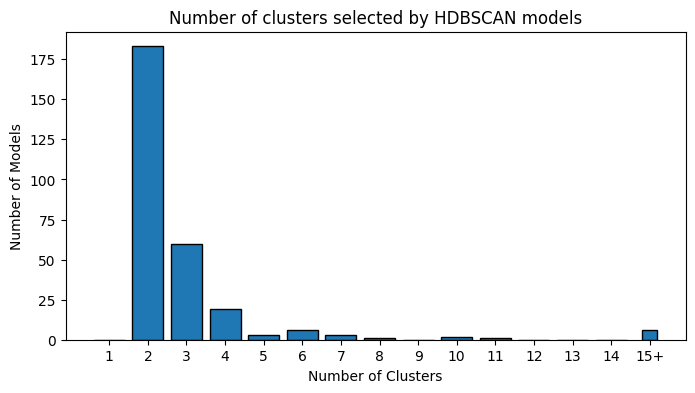

In [33]:
# Histogram of the number of clusters selected by HDBSCAN modelsgrouping the values above 15
bins = list(range(1, 16)) + [15.5]
labels = list(range(1, 15)) + ['15+']
plot_data = hdbscan_all['n_clust'].apply(lambda x: x if x <= 15 else 15.5)

plt.figure(figsize=(8, 4))
plt.hist(plot_data, bins=bins, edgecolor='black', align='left', rwidth=0.8)
plt.xticks(bins[:-1], labels)
plt.xlabel('Number of Clusters')
plt.ylabel('Number of Models')
plt.title('Number of clusters selected by HDBSCAN models')
plt.show()

In [ ]:
# Fitting one of the best models for n=2
scaler = StandardScaler()
data = scaler.fit_transform(data_n)

hdb = HDBSCAN(metric = 'euclidean', min_cluster_size = 4, min_samples = 2)  
pred_clust = hdb.fit_predict(data)
n_clusters = len(set(pred_clust[pred_clust != -1]))

# Plotting datapoints and clusters in 2D space
plt.figure(figsize=(8, 6))

## PCA to define the 2D space
pca = PCA(n_components=2)
reduced_space = pca.fit_transform(data)

## Create hulls around clusters
hull_vertices = []
hull_colors = []
for i in range(n_clusters):
    cluster_points = reduced_space[pred_clust == i]
    if len(cluster_points) > 2:
        hull = ConvexHull(cluster_points)
        hull_vertices.append((
            cluster_points[hull.vertices, 0],
            cluster_points[hull.vertices, 1]
        ))
        hull_colors.append(i)

## Plot datapoints
scatter = plt.scatter(reduced_space[:, 0], reduced_space[:, 1], 
                     c=pred_clust, cmap='tab10', 
                     s=15, edgecolors='k')

## Plot hulls using the same colormap
for vertices, i in zip(hull_vertices, hull_colors):
    plt.fill(vertices[0], vertices[1], 
             alpha=0.7,
             color=scatter.cmap(scatter.norm(i)))

legend = plt.legend(*scatter.legend_elements())
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.title("Clusters with Convex Hulls")
plt.show()

# Aggregate and display results

In [ ]:
best_mod_list = [kmeans_best, ahc_best, hdbscan_best]
best_models = pd.concat(best_mod_list, ignore_index=True)

In [ ]:
best_models

In [ ]:
# Selecting the best performing model on each criteria across model classes eliminates hdbscan models
# Which could mean hdbscan is underperforming
# Or is picking non-convex clusters
# Or that data is non-clusterable!
best_mod_list = [kmeans_best, ahc_best, hdbscan_best]
best_models = pd.concat(best_mod_list, ignore_index=True)

best_silhouette = best_models.sort_values('silhouette', ascending=False).iloc[0]
best_ch = best_models.sort_values('calinski_harabasz', ascending=False).iloc[0]
best_db = best_models.sort_values('davies_bouldin', ascending=True).iloc[0]
best_dunn = best_models.sort_values('dunn', ascending=False).iloc[0]
best_inertia = best_models.sort_values('inertia', ascending=False).iloc[0]

best_models = pd.DataFrame([best_silhouette, best_ch, best_db, best_dunn, best_inertia])
best_models = best_models.drop_duplicates().reset_index(drop=True)

In [ ]:
best_models

In [ ]:
# Histogram
bins = np.arange(best_models['n_clust'].min() - 0.5, best_models['n_clust'].max() + 1.5, 1)

plt.figure(figsize=(8, 4))
plt.hist(best_models['n_clust'], bins=bins, edgecolor='black', rwidth=0.8)
plt.xlabel('Number of Clusters')
plt.ylabel('Number of Models')
plt.title('Optimal number of clusters according to best models')
plt.show()

# Clusters visualization 

In [ ]:
# PCA to represent the clusters in 2D
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(data)

In [ ]:
# Fit an arbitrary kmeans model
scaler = StandardScaler()
data = scaler.fit_transform(data_n)

kmeans = KMeans(n_clusters=7, random_state=42)
pred_clust = kmeans.fit_predict(data)

### Datapoints alone

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=pred_clust, cmap='tab10', s=20, edgecolors='k')
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.axhline(y=0, color='#333333', linestyle='--', linewidth=1)
plt.axvline(x=0, color='#333333', linestyle='--', linewidth=1)
plt.title("Clusters")
plt.show()

### With decision boundaries

In [ ]:
# Create a grid for boundary visualization in 2D space
x_min, x_max = X_reduced[:, 0].min() - 0.5, X_reduced[:, 0].max() + 0.5
y_min, y_max = X_reduced[:, 1].min() - 0.5, X_reduced[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

# Project grid points back to original space
grid_points_2D = np.c_[xx.ravel(), yy.ravel()]
grid_points_original = pca.inverse_transform(grid_points_2D)

# Predict clusters in the original space
grid_clusters = kmeans.predict(grid_points_original).reshape(xx.shape)

plt.figure(figsize=(8, 6))

# Create scatter plot first to get the color mapping
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], 
                     c=pred_clust, cmap='tab10', 
                     s=15, edgecolors='k')

# Plot boundaries using the same colormap and normalization
plt.contourf(xx, yy, grid_clusters, 
             alpha=0.3, 
             cmap=scatter.cmap,
             norm=scatter.norm)

# Plot centroids with labels
centroids_pca = pca.transform(kmeans.cluster_centers_)
for i, (x, y) in enumerate(centroids_pca):
    plt.text(x, y, str(i), color='white', fontsize=12, 
             ha='center', va='center', fontweight='bold',
             bbox=dict(facecolor='black', edgecolor='none', boxstyle='round,pad=0.2'))

plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.title("Clusters with Decision Boundaries")
plt.show()

### With convex hulls

In [ ]:
plt.figure(figsize=(8, 6))

# Collect all hull vertices
hull_vertices = []
hull_colors = []
for i in range(kmeans.n_clusters):
    cluster_points = X_reduced[pred_clust == i]
    if len(cluster_points) > 2:
        hull = ConvexHull(cluster_points)
        hull_vertices.append((
            cluster_points[hull.vertices, 0],
            cluster_points[hull.vertices, 1]
        ))
        hull_colors.append(i)

# Plot datapoints
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], 
                     c=pred_clust, cmap='tab10', 
                     s=15, edgecolors='k')

# Plot all hulls using the same colormap
for vertices, i in zip(hull_vertices, hull_colors):
    plt.fill(vertices[0], vertices[1], 
             alpha=0.3,
             color=scatter.cmap(scatter.norm(i)))

legend = plt.legend(*scatter.legend_elements())
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.title("Clusters with Convex Hulls")
plt.show()

# Hopkins Statistic

Function from the pyclustertend package, which could not be installed because its depencies are outdated.
See: https://pyclustertend.readthedocs.io/en/latest/_modules/pyclustertend/hopkins.html

In [ ]:
from sklearn.neighbors import BallTree

def hopkins(data_frame, sampling_size):
    if type(data_frame) == np.ndarray:
        data_frame = pd.DataFrame(data_frame)

    # Sample n observations from D:P
    if sampling_size > data_frame.shape[0]:
        raise Exception(
            'The number of sample of sample is bigger than the shape of D')

    data_frame_sample = data_frame.sample(n=sampling_size)

    # Get the distance to their neirest neighbors in D:X
    tree = BallTree(data_frame, leaf_size=2)
    dist, _ = tree.query(data_frame_sample, k=2)
    data_frame_sample_distances_to_nearest_neighbours = dist[:, 1]

    # Randomly simulate n points with the same variation as in D:Q
    max_data_frame = data_frame.max()
    min_data_frame = data_frame.min()

    uniformly_selected_values_0 = np.random.uniform(min_data_frame[0], max_data_frame[0], sampling_size)
    uniformly_selected_values_1 = np.random.uniform(min_data_frame[1], max_data_frame[1], sampling_size)

    uniformly_selected_observations = np.column_stack((uniformly_selected_values_0, uniformly_selected_values_1))
    if len(max_data_frame) >= 2:
        for i in range(2, len(max_data_frame)):
            uniformly_selected_values_i = np.random.uniform(min_data_frame[i], max_data_frame[i], sampling_size)
            to_stack = (uniformly_selected_observations, uniformly_selected_values_i)
            uniformly_selected_observations = np.column_stack(to_stack)

    uniformly_selected_observations_df = pd.DataFrame(uniformly_selected_observations)

    # Get the distance to their neirest neighbors in D:Y
    tree = BallTree(data_frame, leaf_size=2)
    dist, _ = tree.query(uniformly_selected_observations_df, k=1)
    uniformly_df_distances_to_nearest_neighbours = dist

    # Return the hopkins score
    x = sum(data_frame_sample_distances_to_nearest_neighbours)
    y = sum(uniformly_df_distances_to_nearest_neighbours)

    if x + y == 0:
        raise Exception('The denominator of the hopkins statistics is null')

    return x / (x + y)[0]

In [ ]:
float(hopkins(data_n.values, data_n.shape[0]))